___
___
<h1><center>
Multispecies Thomas-Fermi $\langle Z\rangle$ Solver
</center></h1>

<h3><center>
Contributors: Jim Glosli, Liam Stanton, Michael S. Murillo
</center></h3>

<h3><center>
Python Notebook: Michael S. Murillo
</center></h3>


### Cite:
* _A Multi-Scale Molecular Dynamics Model for Heterogeneous Charged Systems_
    * L. G. Stanton, J. N. Glosli and M. S. Murillo
    * to appear in **Physical Review X** (2018)

### See also:
* Jeff Haack wrote versions in other languages/formats. Click [here](https://github.com/MurilloGroupMSU/Dense-Plasma-Properties-Database/tree/master/database/Thomas_Fermi_Ionization).

### More on ionization in dense plasmas (click [here](http://dh-web.org/physics/pubs/PhysRevE.87.063113.pdf)):
* _Partial ionization in dense plasmas: Comparisons among average-atom density functional models_
    * Michael S. Murillo, Jon Weisheit, Stephanie B. Hansen, and M. W. C. Dharma-wardana
    * _Phys. Rev. E_ **87**, 063113 (2013)
___
___

___
### Libraries

The libraries are mostly for plotting and array use; but, the most important library is `fsolve` from SciPy, which is a [multidimensional root solver](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html). From that documentation, we see that `fsolve` "is a wrapper around MINPACK’s hybrd and hybrj algorithms"; details can be found [here](https://www.math.utah.edu/software/minpack/minpack/hybrd.html).

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fsolve
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
plt.rc('font', size = 20)
plt.style.use("seaborn-deep")

____
### Algorithm

We imagine that the total volume containing all $N$ species is subdivided into cells that contain a single nucleus. We know in advance how many cells there are because we know the number densities of all of the species; however, we do _not_ know the size of the cells. Higher-$Z$ elements will generate a larger pressure that compresses cells containing lower-$Z$ elements (and vice versa). 

We assume that we know how to compute the mean ionization state (MIS) of an element in its cell, which naturally suggests the use of an average-atom (AA) model. Below is a function that implements (through a fit) an AA model that accepts as input the nuclear charge $Z$, the electron temperature $T$ (note that there is no ionic temperature in this model), and the density that cell _thinks it is at_. This anthropomorphism arises from the AA picture: inside the cell the matter is only influenced by the remaining system through the boundary condition, which is merely the size of the cell. Thus, we need to pass the _effective_ size of the cell to the MIS function to make it aware of compression causes by the other particles. We will refer to this effective cell volume as $v_\alpha$, where $\alpha$ is the species index. 

If the free electrons produced by each cell are approximately uniform in that cell, then we can can compute the MIS $Z^*_\alpha $ as
$$Z^*_\alpha( v_\alpha; Z, T_e)  = v_\alpha n_e.$$

Again, the MIS must be obtained from a full AA calculation, which we provide below in the `zbar` function. We do not, however, know $n_e$ yet. Since $n_e$ is the same for all cells, independent of species, we also have
$$ n_e = \sum_\alpha n_\alpha Z^*_\alpha( v_\alpha; Z, T_e).$$

The $n_\alpha$ are the _real_ number densities of the species. Combining these results we obtain
$$ Z^*_\alpha( v_\alpha; Z, T_e) - v_\alpha \sum_{\alpha'} n_{\alpha'} Z^*_{\alpha'}( v_{\alpha'}; Z, T_e) = 0,$$

which is an $N$-dimensional set of (non-linear) algebraic equations. This can be written the suggestive form
$$ \bar{n}_\alpha Z^*_\alpha( \bar{n}_\alpha; Z, T_e) - \sum_{\alpha'} n_{\alpha'} Z^*_{\alpha'}( \bar{n}_{\alpha'}; Z, T_e) = 0,$$

where $\bar{n}_\alpha$ is the _effective_ density of species $\alpha$, and is what the MIS function receives. We see that we need to find the roots of $N$ equations for the $\bar{n}_\alpha$. This is readily done with [SciPy's `fsolve` library](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html). 

___
### Basic TF $\langle Z \rangle$ Code

In [6]:
def zbar(Z, num_density, T):
    """
    Finite Temperature Thomas Fermi Charge State using 
    R.M. More, "Pressure Ionization, Resonances, and the
    Continuity of Bound and Free States", Adv. in Atomic 
    Mol. Phys., Vol. 21, p. 332 (Table IV).
    
    Z = atomic number
    num_density = number density (1/cc)
    T = temperature (eV)
    """

    alpha = 14.3139
    beta = 0.6624
    a1 = 0.003323
    a2 = 0.9718
    a3 = 9.26148e-5
    a4 = 3.10165
    b0 = -1.7630
    b1 = 1.43175
    b2 = 0.31546
    c1 = -0.366667
    c2 = 0.983333
    
    convert = num_density*1.6726e-24
    R = convert/Z
    T0 = T/Z**(4./3.)
    Tf = T0/(1 + T0)
    A = a1*T0**a2 + a3*T0**a4
    B = -np.exp(b0 + b1*Tf + b2*Tf**7)
    C = c1*Tf + c2
    Q1 = A*R**B
    Q = (R**C + Q1**C)**(1/C)
    x = alpha*Q**beta

    return Z*x/(1 + x + np.sqrt(1 + 2.*x))

___
### Function for Root Solver

In [7]:
def make_zero(current_densities):
    """ This function creates the function that the root solver attempts to make zero; see
    algorithm description above."""
    
    equations = np.array([])
    
    species_sum = 0
    for s in range(len(current_densities)):
        species_sum += densities[s]*zbar(nuclear_charges[s], current_densities[s], T)
    
    for s in range(len(current_densities)):
        equations = np.append(equations, \
                              current_densities[s]*zbar(nuclear_charges[s], current_densities[s], T) -\
                              species_sum)
       
    return equations

____
### Main Loop

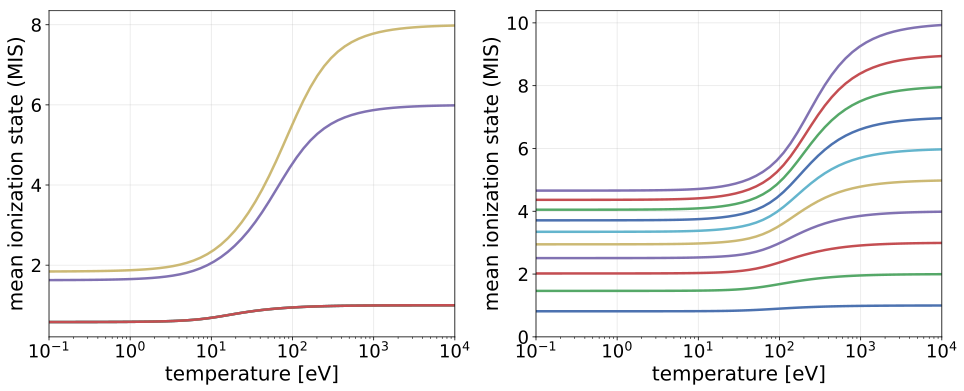

In [8]:

# Set size of final figure.
fig = plt.figure(figsize=(16, 6))

# Make first plot. You can use subplots to make an array of plots for different cases.
# The example given here creates two plots, side by side. 
plt.subplot(121)

# Temperature range for first plot.
temp_low_log = -1 # log of eV
temp_high_log = 4
temp_number = 60 # points to plot
temperatures = np.logspace(temp_low_log, temp_high_log, temp_number)

# Physical properties for first plot.
densities = np.array([1,1,1,5,0.5])*1e22 # in 1/cc
nuclear_charges = [1,1,1,6,8]
total_density = np.sum(densities)
# initial arrays
initial_densities = np.ones(len(densities))*total_density
zbars = np.empty(shape=[0,len(initial_densities)])

for T in temperatures:
    
    # for this T, get the effective densities; note that T is a global variable (bad!)
    effective_densities = fsolve(make_zero, initial_densities)
    
    # knowing the effective densities, find/store the MIS associated with them
    temp_result = np.array([])
    for s in range(len(densities)):
        temp_result = np.append(temp_result, zbar(nuclear_charges[s], effective_densities[s], T))
        
    # store these MIS in the cummulative results array; then, next T
    zbars = np.append(zbars, [temp_result], axis = 0)

plt.semilogx(temperatures, zbars, linewidth=2.5)
plt.xlabel('temperature [eV]')
plt.ylabel('mean ionization state (MIS)')
# plt.title('Multispecies Ionization Levels Versus Temperature')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(alpha = 0.3)
plt.xlim(0.1,1e4)


# Make second plot. You can use subplots to make an array of plots for different cases.
# The example given here creates two plots, side by side. 
plt.subplot(122)
# Temperature range for second plot.
temp_low_log = -1 # log of eV
temp_high_log = 4
temp_number = 60 # points to plot
temperatures = np.logspace(temp_low_log, temp_high_log, temp_number)

# Physical properties for second plot.
densities = np.array([1,1,1,1,1,1,1,1,1,1])*1e23 # in 1/cc
nuclear_charges = [1,2,3,4,5,6,7,8,9,10]
total_density = np.sum(densities)
initial_densities = np.ones(len(densities))*total_density
zbars = np.empty(shape=[0,len(initial_densities)])

# Main loop over temperatures for second plot.
for T in temperatures:
    
    # for this T, get the effective densities; note that T is a global variable (bad!)
    effective_densities = fsolve(make_zero, initial_densities)
    # knowing the effective densities, find/store the MIS associated with them
    temp_result = np.array([])
    for s in range(len(densities)):
        temp_result = np.append(temp_result, zbar(nuclear_charges[s], effective_densities[s], T))
        
    # store these MIS in the cummulative results array; then, next T
    zbars = np.append(zbars, [temp_result], axis = 0)

# Now that we are done, we can construct the plots.
plt.semilogx(temperatures, zbars, linewidth=2.5)
plt.xlabel('temperature [eV]')
plt.ylabel('mean ionization state (MIS)')
plt.ylim(0,)
plt.xlim(0.1,1e4)
# plt.title('Multispecies Ionization Levels Versus Temperature')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.grid(alpha = 0.3)  

# Output final figure to a file. Different formats can be chosen by
# changing the file extension (e.g., .png). One could also write the data to 
# a file for use elsewhere or build the code given in this notebook into a 
# module that can be imported into other codes. See GitHub for versions in
# other languages.
plt.savefig('zbars.pdf')